# Extended Abstract Figures
Ellie Traill 2022

This notebook contains the code created and used in the extended abstract: PAVEMENT WATERING AS AN URBAN HEAT MITIGATION TECHNIQUE: A CASE STUDY IN MELBOURNE, AUSTRALIA.

## Packages

In [1]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
from matplotlib import ticker
import matplotlib.colors as colors
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta
import os
import copy
import string

In [2]:
# set matplotlib parameters
%matplotlib inline

plt.rcParams["font.family"] = "Times New Roman" # Choose a nice font here
plt.rcParams['font.size'] = 7 # standard font size
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = "Times New Roman"
plt.rcParams['mathtext.it'] = "Times New Roman"
plt.rcParams['figure.facecolor'] = 'white' # make sure background isn't transparent
plt.rcParams['figure.dpi'] = 100

## Constants

In [3]:
# get the current directory -> should hold the experiment data files
DATA_DIR = os.getcwd()

In [4]:
# data recorded from hand-written experiment notes
# time periods are the individual experiment start and end times
TIME_PERIODS = [
    [['2022-02-08 11:10', '2022-02-08 13:45'], ['2022-02-08 14:25', '2022-02-08 16:55'], ['2022-02-08 19:11', '2022-02-08 21:08']],
    [['2022-02-12 11:28', '2022-02-12 14:40'], ['2022-02-12 15:02', '2022-02-12 17:25'], [ '2022-02-12 19:18', '2022-02-12 21:07']],
    [['2022-02-13 11:30', '2022-02-13 14:20'], ['2022-02-13 15:28', '2022-02-13 18:40'], ['2022-02-13 19:18', '2022-02-13 21:13']]
]
# watering times is the beginning of watering
WATERING_TIMES = [
    [['2022-02-08 11:40'], ['2022-02-08 14:55'], ['2022-02-08 19:30']],
    [['2022-02-12 11:58'], ['2022-02-12 15:32'], ['2022-02-12 19:30']],
    [ 
        ['2022-02-13 12:00','2022-02-13 12:15','2022-02-13 12:30','2022-02-13 12:45'],
        ['2022-02-13 15:58','2022-02-13 16:15','2022-02-13 16:30','2022-02-13 16:45'],
        ['2022-02-13 19:26']
    ]
]
# watering fin times is when watering was finished
WATERING_FIN_TIMES = [
    [['2022-02-08 11:50'], ['2022-02-08 15:05'], ['2022-02-08 19:37']],
    [['2022-02-12 12:02'], ['2022-02-12 15:36'], ['2022-02-12 19:35']],
    [ 
        ['2022-02-13 12:05','2022-02-13 12:17','2022-02-13 12:32','2022-02-13 12:47'],
        ['2022-02-13 16:03','2022-02-13 16:17','2022-02-13 16:32','2022-02-13 16:47'],
        ['2022-02-13 19:30']
    ]
]
# station approx dry is when it was roughly dry beneath the experimental weather station
STATION_APPROX_DRY = [
    [['2022-02-08 12:45'], ['2022-02-08 15:55'], ['2022-02-08 21:05']],
    [['2022-02-12 13:40'], ['2022-02-12 16:25'], ['2022-02-12 20:40']],
    [['2022-02-13 13:20'], ['2022-02-13 17:40'], ['2022-02-13 20:30']],
]

# the total amount of water used to wet the surface
# actual amount subtracted by approx runoff and build up along perimeter 
APPROX_WATER_AMOUNT = [
    [[100-60], [100-60], [100-60]],
    [[60-20], [60-20], [60-20]],
    [[120-20], [120-20], [60-20]],
]

In [5]:
# temp profile measurement heights
TEMP_PROFILE_HEIGHTS = [1.5, 0.75, 0.35, 0.15, 0.05]
# temp profile column names
TEMP_PROFILE_COL = ["Temp_C(1)", "Temp_C(2)", "Temp_C(3)", "Temp_C(4)", "Temp_C(5)"]
# experiment time categories
EXPERIMENT_TIME_CATEGORIES = ["Midday", "Afternoon", "Evening"]

In [6]:
# plot common customisations
PLT_LW = 0.5

## General Functions

In [7]:
def calc_vpd(temp, rh):
    """
    Calculates the vapour-pressure deficit (vpd) given temperature and relative humidity.
    Uses equation from Allan et al (1998): Crop evapotranspiration-Guidelines for computing crop water requirements-FAO Irrigation and drainage
    Avaliable at: https://www.researchgate.net/publication/235704197_Crop_evapotranspiration-Guidelines_for_computing_crop_water_requirements-FAO_Irrigation_and_drainage_paper_56
    
    Parameters
    ----------
    temp : float
        Temperature in degrees celsius.
    rh : float
        Relative humidity in percent.
    
    Returns
    -------
    vpd : float
        Vapor-pressure deficit in kPa.
        
    """
    # calculate saturation vapour pressure from temp    
    sat_vp = 0.6108 * np.exp( (17.27 * temp) / (temp + 237.3) )
    # calculate VPD from rh and sat_vp
    vpd = sat_vp * (1 - (rh / 100) )
    
    return vpd


In [8]:
def calc_latent_heat_flux(total_seconds_to_dry,
                          water_amount,
                          area = 10*10
                         ):
    """
    Calculates the latent heat flux.
    Q_e = density * latent heat of vaporisation * evaporation rate
    
    Parameters
    ----------
    total_seconds_to_dry : float
        Seconds it took for water to evaporate.
    water_amount : float
        The amount of water put on the ground in litres.
    area : float
        The area the water evaporated from in metres squares. Default is 10 x 10 m as this was the defined plot in the experiments.
        
    Returns
    -------
    latent_heat_flux : float
        Latent heat flux in W/m^2.
        
    """
    # height of water in mm
    water_height = water_amount/area
    # evaporated amount in m/s
    evaporated = water_height / total_seconds_to_dry / 1000
    # density in k/m^3
    water_density = 1000
    # heat of vaporisation in J/kg
    heat_vaporisation = 2.5 * 10**6
    # calculate latent in W/m2
    latent_heat_flux = water_density * heat_vaporisation * evaporated

    return latent_heat_flux


In [9]:
def restrict_time_period(data, start_time, end_time, end_inclusive = True):
    """
    Restricts a dataframe indexed by datetime to an interval. 
    The start time is included, and by default the end time is also included.
    
    Parameters
    ----------
    data : panda.DataFrame
        DataFrame containing the data to restrict.
    start_time : String
        The start time given in a format that can be converted to a datetime.
    end_time : String
        The end time given in a format that can be converted to a datetime.
    end_inclusive : boolean
        Indicates whether to include the end time or not in restriction.
    
    Returns
    -------
    data_slice : panda.DataFrame
        DataFrame containing the only the requested time period.
    
    """
    # include the start time data point by minusing 5 milliseconds
    start_remove = pd.to_datetime(start_time)  - timedelta(milliseconds=5)
    # if neccesary, include the end time data point by plusing 5 milliseconds
    if end_inclusive:
        end_remove = pd.to_datetime(end_time) + timedelta(milliseconds=5)
    else:
        end_remove = pd.to_datetime(end_time)
    # restrict the dataframe based on time period
    data_slice = data.copy()
    data_slice = data_slice.loc[(data_slice.index > start_remove) & (data_slice.index < end_remove)]

    return data_slice

## Read Data

### Functions

In [10]:
def get_campbell_data(file_location, specified_columns = False):
    """
    Reads data exported from campbell data loggers. Data is indexed by datetime, and also converted to floats.
    
    Parameters
    ----------
    file_location : String
        The location of the campbell file.
    specified_columns : False or list
        False to return all columns, list to specify which data columns to return.
    
    Returns
    -------
    campbell : panda.DataFrame
        DataFrame containing the campbell logger data.
    
    """
    # read data in - ignore first line  
    campbell = pd.read_csv(file_location, header=[1])
    
    # clean up data by drop units and type in first and second row
    campbell = campbell.drop([0,1])
    
    # convert timestamp to datetime 
    campbell['TIMESTAMP'] = pd.to_datetime(campbell['TIMESTAMP'])
    
    # make datetime the index
    campbell = campbell.set_index('TIMESTAMP')
    
    # change data to float
    campbell = campbell.astype(float)
    
    # as experimental station has no wind, but need to compare both experimental and control station dataframes
    # so if there is no wind column add an empty one
    if 'WS_ms' not in campbell.columns and 'WS_ms' in specified_columns:
        campbell["WS_ms"] = np.empty(len(campbell))
    
    # only return specified columns
    if specified_columns:
        campbell = campbell.loc[:,specified_columns]
    
    return campbell

In [11]:
def filter_8(data):
    """
    Known mistakes occured during the experiment conducted on the 8th, and showed up in the data loggers:
    Tp 0.15 spike at (2022-02-08 16:25:00 2022-02-08 16:25:30)
    This function filters the data.
    
    Parameters
    ----------
    data : panda.DataFrame
        DataFrame containing the data with errors.
    
    Returns
    -------
    data : panda.DataFrame
        DataFrame with the errornous data removed.
    
    """
    
    # removing human-caused temp spike
    if "Temp_C(4)" in data.columns:
        spike_time = pd.to_datetime('2022-02-08 16:25:00')
        spike_time2 = pd.to_datetime('2022-02-08 16:25:30')
        data.loc[(data.index == spike_time) | (data.index == spike_time2), ("Temp_C(4)")] = np.nan
        
    return data
    

def filter_13(data):
    """
    Known mistakes occured during the experiment conducted on the 13th, and showed up in the data loggers:
    13th Morning: Tp 1.5, 0.15, globe temp 
    13th Afternoon: all between 2022-02-13 16:15 to 2022-02-13 16:25, 1.5 and 0.15 before latter time, globe temp
    13th Evening: Tp 0.15 (spike at 19:19:00), fixed globe temp at 2022-02-13 16:40
    This function filters the data.
    
    Parameters
    ----------
    data : panda.DataFrame
        DataFrame containing the data with errors.
    
    Returns
    -------
    data : panda.DataFrame
        DataFrame with the errornous data removed.
    
    """
   
    # dealing with incorrect 1.5 m and 0.15 m sensors:
    fixed_time = pd.to_datetime('2022-02-13 16:26')
    
    for tp in ["Temp_C(1)", "Temp_C(4)"]:
        if tp in data.columns:
            data.loc[(data.index < fixed_time), (tp)] = np.nan
    
    # time when fixing above two sensors where other sensors were effected
    start_of_other_error = pd.to_datetime('2022-02-13 16:15')
    
    for tp in ["Temp_C(2)", "Temp_C(3)", "Temp_C(5)"]:
        if tp in data.columns:
            data.loc[(data.index > start_of_other_error) & (data.index < fixed_time), (tp)] = np.nan
    
    # dealing with globe temp issues
    fixed_time_globe = pd.to_datetime('2022-02-13 16:40')
    
    if "BG_Temp" in data.columns:
        data.loc[(data.index < fixed_time_globe), ("BG_Temp")] = np.nan

    # dealing with temp spike
    if "Temp_C(4)" in data.columns:
        spike_time = pd.to_datetime('2022-02-13 19:19:00')
        spike_time2 = pd.to_datetime('2022-02-13 19:19:30')
        data.loc[(data.index == spike_time) | (data.index == spike_time2), ("Temp_C(4)")] = np.nan
        
    return data

In [12]:
def get_all_station_data(columns):
    """
    Get all the relevant experiment data across all experiments and package them together in a dictionary.
    Also corrects relative humidty data if required (value from previous calibration), and calculates VPD.
    
    Parameters
    ----------
    columns : list
        The data columns that are needed for analysis.
    
    Returns
    -------
    all_data : dictionary
        Dictionary containing all the related data of the experiments packaged together.
        Included data: control, experiment, difference, time periods (where the data loggers were running),
        watering start and finsih times, approx dry times, and approx water amount
        
    """
    all_data = {}
    
    # folder names correspond to specific experiment date
    days = ["8", "12", "13"]
    
    # data files are named after the data logger/station
    # CR3000 was data logger at the control site
    # CR5000 was at the experimental site
    stations = ["CR3000", "CR5000"]
    
    # loop through all experiment days
    for i, day in enumerate(days):
        
        # set up empty array to fill with station data
        data = [] 
        
        for station in stations:
            # data split into two files, get all data and combine them
            # data files were directly copied from data loggers
            data1 = get_campbell_data(DATA_DIR + "\\" + day + '.02.2022\\' + station + '_Table1.dat', columns)
            data2 = get_campbell_data(DATA_DIR + "\\" + day + '.02.2022\\evening\\' + station + '_Table1.dat', columns)
            combined = pd.concat([data1, data2]).drop_duplicates()
            # restrict data to the specific day (files may contain data from previous experiments or days)
            combined = restrict_time_period(combined, '2022-02-' + day + ' 00:00', '2022-02-' + day + ' 23:59')
            # add data to array
            data.append(combined)
        
        
        control = data[0]
        experiment = data[1]
        # filter data where known sensor error occurred
        if day == "13":
            control = filter_13(control)
            experiment = filter_13(experiment)
        elif day == "8":
            control = filter_8(control)
            experiment = filter_8(experiment)
         
        # correct relative humidity data if required
        # also get VPD data
        if "RH" in columns:
            control["RH_Corrected"] = control["RH"]
            experiment["RH_Corrected"] = experiment["RH"]+2.455758865248221
            
            if "Temp_C(1)" in columns:
                control["VPD"] = calc_vpd(control["Temp_C(1)"], control["RH_Corrected"])
                experiment["VPD"] = calc_vpd(experiment["Temp_C(1)"], experiment["RH_Corrected"])
        
        
        # difference calculated as experimental (CR5000) - control (CR3000)
        difference = experiment - control
        
        # package all the related data together 
        all_data[day] = {
            "control" : control,
            "experiment" : experiment,
            "difference" : difference,
            "time_periods": TIME_PERIODS[i],
            "watering_start_times" : WATERING_TIMES[i],
            "watering_fin_times" : WATERING_FIN_TIMES[i],
            "approx_dry_times": STATION_APPROX_DRY[i],
            "approx_water_amount": APPROX_WATER_AMOUNT[i]
        }
    
    
    return all_data 

### Read Data

In [13]:
all_data = get_all_station_data(["Temp_C(1)",  "Temp_C(2)", "Temp_C(3)", "Temp_C(4)", "Temp_C(5)", "RH", "CM3Up", "NetTot", 'WS_ms'])
all_data

{'8': {'control':                      Temp_C(1)  Temp_C(2)  Temp_C(3)  Temp_C(4)  Temp_C(5)  \
  TIMESTAMP                                                                    
  2022-02-08 10:07:30      22.84      23.04      23.34      23.80      23.89   
  2022-02-08 10:08:00      22.81      22.96      23.42      23.90      23.98   
  2022-02-08 10:08:30      22.87      23.09      23.48      23.91      23.95   
  2022-02-08 10:09:00      22.72      22.88      23.14      23.69      23.84   
  2022-02-08 10:09:30      22.68      22.78      23.09      23.57      23.80   
  ...                        ...        ...        ...        ...        ...   
  2022-02-08 21:06:30      25.83      25.87      26.14      26.22      26.45   
  2022-02-08 21:07:00      25.47      25.57      25.63      25.86      26.21   
  2022-02-08 21:07:30      25.56      25.56      25.70      25.81      26.19   
  2022-02-08 21:08:00      25.58      25.58      25.75      25.83      26.12   
  2022-02-08 21:08:30   

In [14]:
all_data["8"]["control"].head()

,Temp_C(1),Temp_C(2),Temp_C(3),Temp_C(4),Temp_C(5),RH,CM3Up,NetTot,WS_ms,RH_Corrected,VPD
TIMESTAMP,,,,,,,,,,,
2022-02-08 10:07:30,22.84,23.04,23.34,23.80,23.89,43.67,578.5,358.2,0.000,43.67,1.567306
2022-02-08 10:08:00,22.81,22.96,23.42,23.90,23.98,43.75,576.4,356.7,2.798,43.75,1.562239
2022-02-08 10:08:30,22.87,23.09,23.48,23.91,23.95,43.01,578.9,357.1,1.625,43.01,1.588552
2022-02-08 10:09:00,22.72,22.88,23.14,23.69,23.84,42.33,583.6,361.5,2.620,42.33,1.592966
2022-02-08 10:09:30,22.68,22.78,23.09,23.57,23.80,41.94,586.1,364.0,1.727,41.94,1.599854


## Temperature Profile Quantiles

### Functions

In [15]:
def get_temp_profile_boxplot(differences, 
                             start_time,
                             watering_start_time, 
                             watering_fin_time, 
                             dry_time,
                             specify_ax = None,
                             box_col = None
                            ):
    """
    Plots two box plots for each temp profile height, 
    one for both dry (before watering) and one for one wet (during wet period).
    
    Parameters
    ----------
    differences : panda.DataFrame
        The DataFrame containing the difference between the experimental and control station.
    start_time : String
        The start time that the stations began logging given in a format that can be converted to a datetime.
    watering_start_time : String
        The start time of watering given in a format that can be converted to a datetime.
    watering_fin_time : String
        The time when watering was finished given in a format that can be converted to a datetime.
    dry_time : String
        The time when the watered plot became dry in a format that can be converted to a datetime.
    specify_ax : None or matplotlib.axes
        The axes to plot the boxplots on, if none an axes will be generated.
    box_col : None or list
        A list containing the colours of the box plots.
    
    Returns
    -------
    ax[0] : matplotlib.axes
        The axes that the boxplots were plotted on.
        
    """
    # restrict dataframe to temp profile data only
    diff = differences[TEMP_PROFILE_COL]
    
    # organise the data into before and during wet period
    before_watering = restrict_time_period(diff, start_time, watering_start_time)
   
    wet_period = restrict_time_period(diff, watering_fin_time, dry_time)
    
    # set up figure if no ax specified
    if not specify_ax:
        fig, ax = plt.subplots(1, figsize=(6,8))
    else:
        ax = specify_ax
    
    # specify colours if none were given
    if not box_col:
        col = ["crimson", "dodgerblue"]
    else:
        col = box_col
    
    # twin axes as unexpected behaviour occurs when plotting two boxplots at the same position
    ax2 = ax.twinx()
    ax = [ax, ax2]
    
    # for box positions, need 4, 3 ... 0 (reversed arange) to ensure 1.5 m is plotted at the top
    # https://stackoverflow.com/questions/15748001/reversed-array-in-numpy
    box_pos = np.arange(0, 5)
    box_pos = box_pos[::-1]
    
    # plot format
    alpha = 0.5
    box_wid = 0.5
    # loop through and plot for each period (both dry and one wet)
    for i, data in enumerate([before_watering, wet_period]):
        # plot the boxplots
        # customised the look based on vibes
        # show mean and median line
        data.boxplot(ax = ax[i], 
                     grid=False,  
                     positions = box_pos,
                     showmeans = True, 
                     meanline = True, 
                     sym="", 
                     widths = box_wid,
                     patch_artist = True, 
                     vert = False, 
                     boxprops=dict(facecolor=col[i], ec="None", alpha = 0.2),
                     capprops=dict(color=col[i], alpha = alpha),
                     whiskerprops=dict(color=col[i], alpha = alpha),
                     flierprops=dict(color="None"),
                     medianprops=dict(color=col[i]),
                     meanprops=dict(color=col[i], ls=":"))
        
        # plot the points that make up the box plot
        # randomise the y-axis points so that scatter is not on a straight line
        # https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib
        scatter_y = []
        # loop through each height to get some random points for each height
        for h in box_pos:
            scatter_y.append(np.random.normal(h, box_wid/2.3/3, size=len(data)))
        # convert DataFrame to numpy and transpose to match up data with randomised height    
        data_numpy = data.to_numpy()
        ax[i].scatter(np.transpose(data_numpy), scatter_y, s = 10, alpha = 0.2, c = col[i], ec = "None", marker='.', zorder=0)
        
    # plot vertical line at 0 for reference
    ax[0].axvline(0, c='black', linestyle=':', alpha = 0.3)
    # set axis label as temp profile heights and customise look of plot    
    for axes in ax:
        axes.set_yticklabels(TEMP_PROFILE_HEIGHTS)
        for axis in ['top','bottom','left','right']:
            axes.spines[axis].set_linewidth(PLT_LW)
    ax[0].tick_params(width=PLT_LW,which='both',direction='in')
    # make attributes of the twin axes disappear
    ax[1].set_yticks([])
    ax[1].set_yticklabels([])
    
    return ax[0]


In [16]:
def plot_all_temp_profile_box_plot(all_data, savefig = False):
    """
    Calls get_temp_profile_boxplot() for every single experiment and formats the plot.
    
    Parameters
    ----------
    all_data : dictionary
        Dictionary containing all the related data of the experiments packaged together. See function get_all_station_data().
    savefig : boolean
        True to save the figure.
    
    Returns
    -------
    None
        
    """    
    
    # set up figure with 3 by 3 plots
    fig, ax = plt.subplots(3, 3)
    # define column labels
    col_labels = EXPERIMENT_TIME_CATEGORIES
    # set up colours
    section_col = ["deeppink", "darkviolet"]
    box_col = ["crimson", "dodgerblue"]
    
    # ready to label each plot with letter
    # get the alphabet as a list
    # https://stackoverflow.com/questions/16060899/alphabet-range-in-python
    subplot_label = list(string.ascii_lowercase)
    
    # loop through each day in the dictionary containing all data
    for j, (day, var) in enumerate(all_data.items()):
        
        # loop through each timeperiod, which corresponds to an experiment
        for i in range(len(var['time_periods'])):
            # plot the experiment boxplots
            get_temp_profile_boxplot(
                var['difference'],
                var['time_periods'][i][0],
                var['watering_start_times'][i][0],
                var['watering_fin_times'][i][0],
                var['approx_dry_times'][i][0],
                specify_ax = ax[j, i],
                box_col = box_col
            )
            # if it isnt on the outer right side, don't label the axes
            if i != 0:
                ax[j, i].set_yticklabels([])
            
            # label the columns according to their time of day category
            if j == 0:
                ax[j, i].set_title(col_labels[i], color = section_col[1], fontsize = 9)
           
            # need index from 0 to 8 for alphabet subplot labelling
            # j * 3 + i will get 0, 1...8 in order
            # could also define a new variable and manually increment at the end of each loop
            lab_ind = j * 3 + i
            ax[j, i].text(0.1, 0.95, subplot_label[lab_ind], transform=ax[j, i].transAxes, fontsize=9, va='top',ha='right', weight = 'bold')

        # label the rows according to the experiment date
        ax[j, 2].yaxis.set_label_position("right")
        ax[j, 2].set_ylabel(day+r"$^{\rm th}$", rotation = "horizontal", labelpad=10, color = section_col[0], fontsize = 9)

        
    # label axes
    ax[1][0].set_ylabel('Height (m)', fontsize = 9, labelpad=5)        
    ax[2][1].set_xlabel('Δ Air Temp (°C)', fontsize = 9, labelpad=5)
    
    # adjust subplot positioning
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # manually create legend
    led_handles = []
    for lab, c in zip(["Both Dry", "One Wet"], box_col):
        led_handles.append(Rectangle((0,0), 0, 0, label=lab, color= c, alpha=0.2))
        
    fig.legend(handles = led_handles, bbox_to_anchor = (0.9,0.88), bbox_transform=fig.transFigure,
               ncol=1, markerfirst = True, frameon=True, loc='upper left',fontsize = 8)    
    
    # set figure size
    fig_wid = 180 / 25.4 
    fig_len = fig_wid + (fig_wid/4)
    fig.set_size_inches(fig_wid,fig_len)
    
    if savefig:
        fig.savefig('all_temp_profile_box_plot.png', bbox_inches='tight', dpi=600)
    return

In [17]:
def plot_temp_profile_box_plot_abstract(all_data, day, exp_no, savefig = False):
    """
    Plots one experiments boxplots and customises for the purpose of the abstract.
    
    Parameters
    ----------
    all_data : dictionary
        Dictionary containing all the related data of the experiments packaged together. See function get_all_station_data().
    day : String
        The day of the individual experiment to plot,
    exp_no : int
        The experiment number of that day, should be 0, 1 or 2.
    savefig : boolean
        True to save the figure.
    
    Returns
    -------
    None
        
    """    
    
    # set up figure with 1 plot
    fig, ax = plt.subplots(1)
    
    box_col = ["crimson", "dodgerblue"]
    
    get_temp_profile_boxplot(
                all_data[day]['difference'],
                all_data[day]['time_periods'][exp_no][0],
                all_data[day]['watering_start_times'][exp_no][0],
                all_data[day]['watering_fin_times'][exp_no][0],
                all_data[day]['approx_dry_times'][exp_no][0],
                specify_ax = ax,
                box_col = box_col
            )
    
        
    # label axes
    ax.set_ylabel('Height (m)', fontsize = 9, labelpad=5)        
    ax.set_xlabel('Δ Air Temp (°C)', fontsize = 9, labelpad=5)
    
    
    # manually create legend
    led_handles = []
    for lab, c in zip(["Both Dry", "One Wet"], box_col):
        led_handles.append(Rectangle((0,0), 0, 0, label=lab, color= c, alpha=0.2))
        
    fig.legend(handles = led_handles, bbox_to_anchor = (0.5,0.97), bbox_transform=fig.transFigure,
               ncol=2, markerfirst = True, frameon=False, loc='upper center',fontsize = 7)    
    
    # set figure size
    fig_wid =  56 / 25.4
    fig_len = fig_wid + (fig_wid/4)
    fig.set_size_inches(fig_wid,fig_len)
    
    if savefig:
        fig.savefig('one_temp_profile_box_plot.png', bbox_inches='tight', dpi=600)
    return

### Plots

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


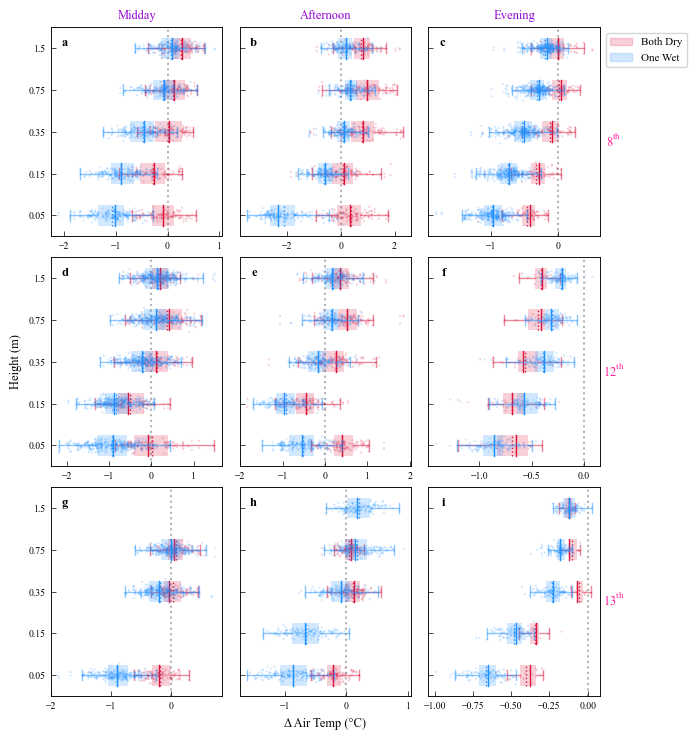

In [18]:
plot_all_temp_profile_box_plot(all_data)

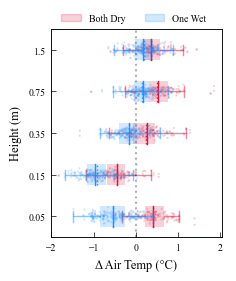

In [19]:
plot_temp_profile_box_plot_abstract(all_data, "12", 1, True)

## Temperature Profile Mean Change and Influencing Factors

### Analyse Data
#### Functions

In [20]:
def get_mean_change(diff_data,
                    start_time,
                    watering_time,
                    watering_fin_time,
                    dry_time,
                    alt_hypo = "greater"
                   ):
    """
    Gets the mean change from the both dry (before watering period) to the one wet (during wet period).
    Also conducts an independent t-test between the two groups to test for significance (True for p > 0.05).
    
    Parameters
    ----------
    diff_data : panda.DataFrame
        The DataFrame containing the difference between the experimental and control station.
    start_time : String
        The start time that the stations began logging given in a format that can be converted to a datetime.
    watering_start_time : String
        The start time of watering given in a format that can be converted to a datetime.
    watering_fin_time : String
        The time when watering was finished given in a format that can be converted to a datetime.
    dry_time : String
        The time when the watered plot became dry in a format that can be converted to a datetime.
    alt_hypo : String
        The alternative hypothesis the independent t-test uses, should be less, greater or two-sided
    
    Returns
    -------
    mean_change, sig_pvalue : array_likes
        The mean change and their corresponding significance, represented as True if below 0.05 or False if not.
        
    """
    # organise data into two dry and one wet periods
    before_watering =  restrict_time_period(diff_data, start_time, watering_time)
    wet_period = restrict_time_period(diff_data, watering_fin_time, dry_time)
        
    # store if the mean is sig diff between means in a numpy array
    # so that numpy logic can be applied later on 
    sig_pvalue = np.array([], dtype = 'bool')
    for column in before_watering:
        # drop na values for each column individually 
        # or risk dropping valid values were invalid values exist in the row
        # independent t test doesn't current allow for omitting na when doing one-sided t-test
        before_col = before_watering[column].dropna()
        wet_col = wet_period[column].dropna()
        sig_diff_c = True if stats.ttest_ind(before_col, 
                                             wet_col, 
                                             equal_var = False, 
                                             alternative = alt_hypo).pvalue < 0.05 else False
        
        sig_pvalue = np.append(sig_pvalue, sig_diff_c)


    # panda mean excludes NA/null values by default
    # wet period minus dry so that negative indicates cooling
    mean_change = wet_period.mean() - before_watering.mean() 

    return mean_change, sig_pvalue

In [21]:
def get_comparison_mean_data(all_data,
                             mean_change_col,
                             control_col, 
                             exp_col, 
                             latent_heat = True
                            ):
    """
    Gets the mean change in data, mean of the control or experimental, and/or the latent heat flux from all data.
    Combines requested data into a DataFrame indexed by the experiment date and time category.
    
    Parameters
    ----------
    all_data : dictionary
        Dictionary containing all the related data of the experiments packaged together. See function get_all_station_data().
    mean_change_col : list
        List of the columns specified to find the mean change in the differences.
    control_col : list
        List of the columns specified to find the mean value during the wet period in the control station.
    exp_col : list
        List of the columns specified to find the mean value during the wet period in the experimental station.
    latent_heat : boolean
        True to calculate and add latent heat flux to DataFrame.
    
    Returns
    -------
    data : panda.DataFrame
        DataFrame with the mean values packaged by experiment.
        
    """   
    # set up column names for DataFrame
    mean_change_col_name =  [col+"_Mean_Change" for col in mean_change_col]
    mean_change_col_sig_name = [col+"_Sig" for col in mean_change_col_name]
    mean_con_name =  [col+"_Con_Mean" for col in control_col]
    mean_exp_name = [col+"_Exp_Mean" for col in exp_col]
    col_names = mean_change_col_name + mean_change_col_sig_name + mean_con_name + mean_exp_name
    
    if latent_heat:
        col_names = col_names + ['Q_e']
    
    # attribute each column to a particular marker shape and hatching for consistency when plotting
    hat = ["////","\\\\\\\\", "----"]
    mar = ['o', '^', 's']
    col_names = col_names + ['Hatch', 'Marker']
    
    # initialise DataFrame
    data = pd.DataFrame([], columns= col_names, index=[])
    
    # prepare DataFrame index (experiment names), below gets M, A, E to represent midday, afternoon, evening
    watering_period = [time[0] for time in EXPERIMENT_TIME_CATEGORIES]
    
    # loop through all the data
    for j, (day, var) in enumerate(all_data.items()):
      
        for i in range(len(var['time_periods'])):
            # define the index by the experiment name (date + time)
            index = day+watering_period[i]
            
            start = var['time_periods'][i][0]
            w_start = var['watering_start_times'][i][0]
            w_end = var['watering_fin_times'][i][0]
            dry = var['approx_dry_times'][i][0]
            
            # get the mean changes in differences from both dry to one wet
            var_mean_change, var_sig = get_mean_change(
                var['difference'][mean_change_col],
                start,
                w_start,
                w_end,
                dry,
            )
            # get mean for the control station during the wet period
            wet_period_con_mean = restrict_time_period(var['control'][control_col], 
                                                       w_end, 
                                                       dry).mean()
            # get mean for the experimental station during the wet period
            wet_period_exp = restrict_time_period(var['experiment'][exp_col], 
                                                  w_end, 
                                                  dry).mean()
            # put all the data together in a messy list
            row_data = [var_mean_change.values] + [var_sig] + [wet_period_con_mean.values] + [wet_period_exp.values]
            
            # calculate and add latent heat if required
            if latent_heat:
                water_amount = var['approx_water_amount'][i][0]
                approx_time_wet_sec = (pd.to_datetime(dry) - pd.to_datetime(w_end)).total_seconds()     
                latent = calc_latent_heat_flux(approx_time_wet_sec, water_amount)
                
                row_data = row_data + [[latent]]
            # add hatching and marker shape specifications
            row_data = row_data + [[hat[i], mar[j]]]
            
            # neated up the list
            # https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
            flattened_row_data = [item for sublist in row_data for item in sublist]
            
            # add the experiment info to the DataFrame
            row = pd.DataFrame([flattened_row_data], columns= col_names, index=[index])
            data = data.append(row)
                    
    return data

In [22]:
def plot_scatter_matrix(mean_df, columns):
    """
    Plots a scatter matrix of the given dataframes for the specified columns. 
    Also computes the r-squared value and prints it on the relevant plot.
    
    Parameters
    ----------
    mean_df : panda.DataFrame
        DataFrame with the mean values packaged by experiment. See function get_comparison_mean_data().
    columns : list
        List of the columns specified to find the mean change in the differences.
    
    Returns
    -------
    None
    
    """
    # plot the scatter matrix
    axes = pd.plotting.scatter_matrix(mean_df[columns], alpha=1, figsize = (10, 10))
    # calculate r^squared value and convert to usable form
    corr = mean_df[columns].corr().to_numpy()**2
    # along the right diagnal write the r^2 on the relevant plot
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

    plt.show()
    
    return

#### Get Data and Initial Analysis

In [23]:
mean_df = get_comparison_mean_data(all_data,
                                      mean_change_col = TEMP_PROFILE_COL,
                                      control_col = ["VPD", "CM3Up", "NetTot", "WS_ms"], 
                                      exp_col = ["VPD", "CM3Up", "NetTot"]
                                     )
mean_df                    

,Temp_C(1)_Mean_Change,Temp_C(2)_Mean_Change,Temp_C(3)_Mean_Change,Temp_C(4)_Mean_Change,Temp_C(5)_Mean_Change,Temp_C(1)_Mean_Change_Sig,Temp_C(2)_Mean_Change_Sig,Temp_C(3)_Mean_Change_Sig,Temp_C(4)_Mean_Change_Sig,Temp_C(5)_Mean_Change_Sig,VPD_Con_Mean,CM3Up_Con_Mean,NetTot_Con_Mean,WS_ms_Con_Mean,VPD_Exp_Mean,CM3Up_Exp_Mean,NetTot_Exp_Mean,Q_e,Hatch,Marker
8M,-0.186196,-0.202071,-0.486550,-0.612394,-0.987665,True,True,True,True,True,2.357268,813.600901,527.558559,2.616333,2.354394,811.660360,595.128829,303.030303,////,o
8A,-0.556285,-0.591977,-0.692134,-0.705629,-2.475407,True,True,True,True,True,2.977336,540.029703,298.766436,1.511475,2.981566,561.256436,383.791881,333.333333,\\\\,o
8E,-0.189700,-0.332562,-0.412877,-0.423836,-0.530856,True,True,True,True,True,2.415660,7.213412,-110.653672,1.710881,2.368269,8.074418,-87.419266,189.393939,----,o
12M,-0.053919,-0.256061,-0.329621,-0.323667,-0.939600,False,True,True,True,True,1.815957,823.990355,538.746954,1.252411,1.848172,827.910660,601.714721,170.068027,////,^
12A,-0.167799,-0.355711,-0.409157,-0.476456,-0.937945,True,True,True,True,True,1.985480,651.404040,381.095960,3.334040,2.015664,680.077778,454.894949,340.136054,\\\\,^
12E,0.192021,0.131887,0.176284,0.122632,-0.180061,False,False,False,False,True,1.383269,9.401565,-103.609924,3.435718,1.366570,10.265870,-83.117481,256.410256,----,^
13M,NaN,-0.085423,-0.211748,NaN,-0.707170,False,True,True,False,True,NaN,807.719868,530.703311,4.755119,NaN,809.850993,621.000662,555.555556,////,s
13A,NaN,0.129867,-0.202198,NaN,-0.652495,False,False,True,False,True,3.263832,446.293333,242.518615,3.688467,3.289991,452.389862,308.649171,429.553265,\\\\,s
13E,0.004439,-0.076111,-0.172664,-0.136584,-0.262450,False,True,True,True,True,3.108937,30.353397,-59.623388,2.845512,3.068395,32.210496,-31.108165,277.777778,----,s


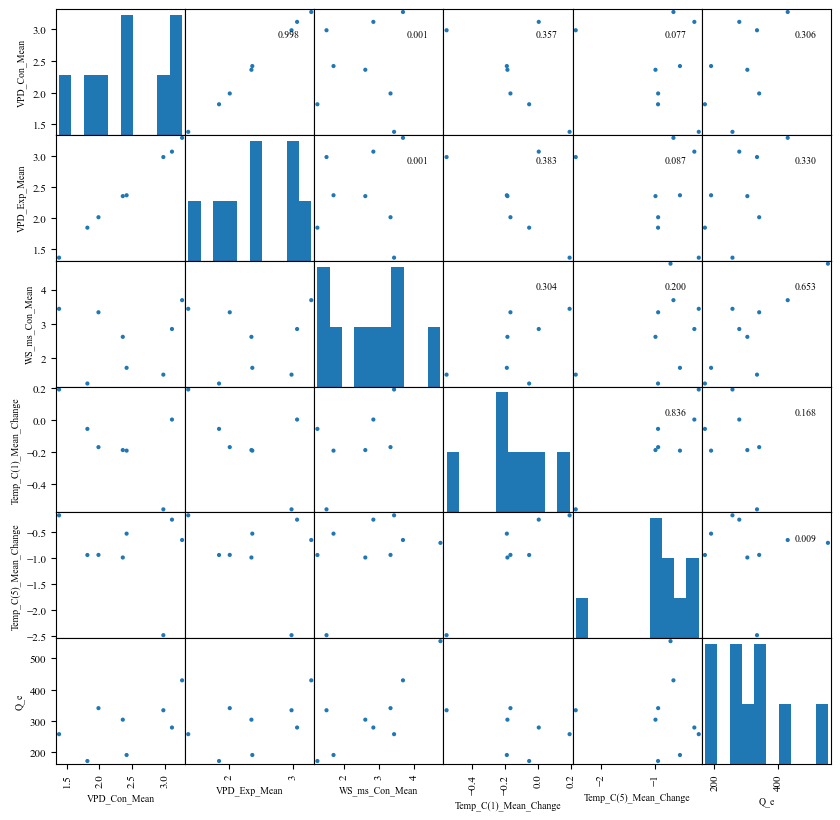

In [24]:
vpd_impact = ['VPD_Con_Mean','VPD_Exp_Mean','WS_ms_Con_Mean', 'Temp_C(1)_Mean_Change','Temp_C(5)_Mean_Change', 'Q_e']

plot_scatter_matrix(mean_df, vpd_impact)

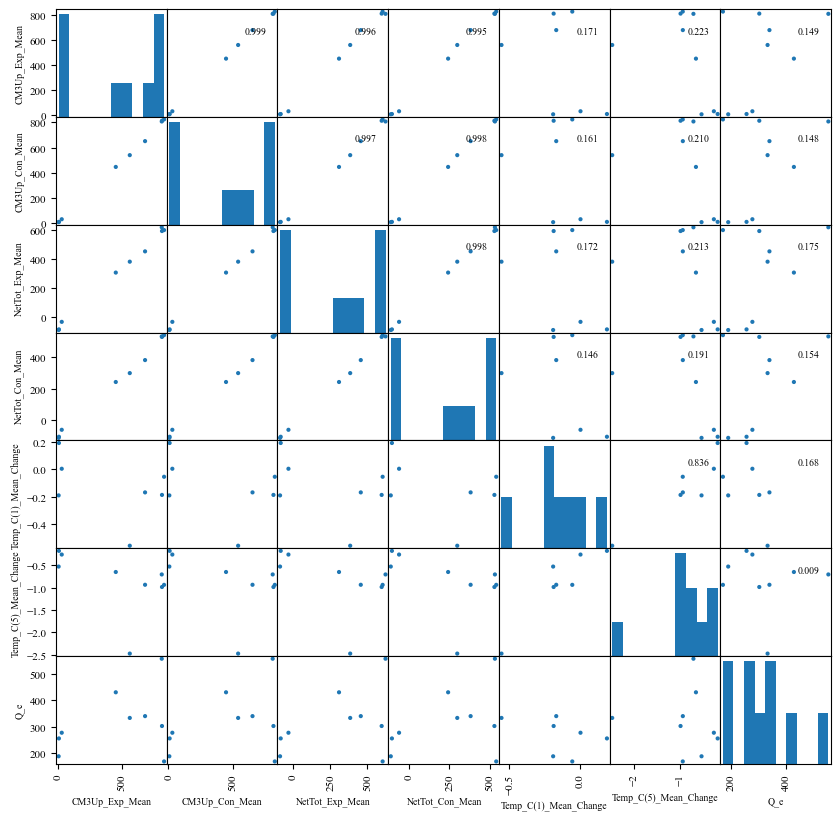

In [25]:
nr_impact = ['CM3Up_Exp_Mean','CM3Up_Con_Mean', 'NetTot_Exp_Mean',  'NetTot_Con_Mean', 'Temp_C(1)_Mean_Change','Temp_C(5)_Mean_Change', 'Q_e']

plot_scatter_matrix(mean_df, nr_impact)

From scatter matrix, can see that control and experiment mean values are highly correlated, experiment is usually slightly more correlated with temp change and q_e. Also can see that incoming solar is highly correlated to net radiation, thus incoming solar energy is likely the dominating factor in net radiation. 

#### Plot Relationships Functions

In [26]:
def plot_mean_change_temp_profile(mean_df, 
                                  scatter_size = 80, 
                                  axes = None, 
                                  leg_col = True,
                                  leg_y_pos = 1.2):
    """
    Plots the mean temp change for each temp profile height, using the dataframe from get_comparison_mean_data().
    
    Parameters
    ----------
    mean_df : panda.DataFrame
        The DataFrame containing the mean change and corresponding significance for each experiment's temp profile height.
    scatter_size : int
        The size of the scatter markers to be plotted.
    axes : None or list of matplotlib.axes
        The axes to plot the mean temp change on, if none an axes will be generated.
    leg_col : boolean
        True for the legend's scatter plot to have the colours.
    leg_y_pos : float
        Y position of legend.
        
    Returns
    -------
    axes : list of matplotlib.axes
        The axes that the change in temp profile was plotted on.
        
    """
    # set up axes
    # initial analysis showed that 2.5 degree cooling at 0.05 m is an outlier
    # to show the distribution in the plots, have a non-continous axis
    # implemented by having two axes next to each other
    if not axes:
        fig = plt.gcf()
        # add_axes([left, bottom, width, height])
        ax_main = fig.add_axes([0.1,0,0.9,1])
        ax_outlier = fig.add_axes([0,0,0.1,1])
        # set figure size
        fig_wid = 56 / 25.4 
        fig_len = fig_wid + (fig_wid/4)
        fig.set_size_inches(fig_wid,fig_len)
    
    else:
        ax_main = axes[0]
        ax_outlier = axes[1]
    
    # set y-values as temp profile heights
    heights = np.array(TEMP_PROFILE_HEIGHTS)
    
    # each experiment corresponds to a colour
    # different colours for different days
    # darker shades fo the colour indicates later in the day
    reds = ['#fecc5c','#fd8d3c','#e31a1c']
    pinks = ['#fbb4b9','#f768a1','#ae017e']
    greens = ['#c2e699','#78c679','#238443']
    col = reds + pinks + greens

    # loop through each experiment 
    for i, (index, row) in enumerate(mean_df.iterrows()):
        # get the data in a nice format to allow for numpy logic 
        tp_mean = (row[[tph + "_Mean_Change" for tph in TEMP_PROFILE_COL]]).astype(float)
        tp_sig = np.array(row[[tph + "_Mean_Change_Sig" for tph in TEMP_PROFILE_COL]], dtype = 'bool')
        
        # set labels for the legend, slighty smaller than actual scatter
        # done to avoid unexpected legend behaviour
        # colour in the legend scatter's if required
        l_col = col[i] if leg_col else "None"
        ax_main.scatter(x =[], y = [], 
                          s = scatter_size - scatter_size/4, color = l_col, hatch = row['Hatch'],
                          marker = row['Marker'], edgecolor="black", alpha = 0.5, label = index)
        # plot significant temp changes with black outline
        ax_main.scatter(x = tp_mean[tp_sig], y = heights[tp_sig], 
                      s = scatter_size, color = col[i], hatch = row['Hatch'],
                      marker = row['Marker'], alpha = 0.5, edgecolor="black")
        # plot insig temp changes with no outline and smaller marker size
        ax_main.scatter(x = tp_mean[~tp_sig], y = heights[~tp_sig], 
                      s = scatter_size - (scatter_size/2.5), color = col[i], hatch = row['Hatch'],
                      alpha=0.5, marker = row['Marker'])
        # plot line joining the different temp changes together
        ax_main.plot(tp_mean[~np.isnan(tp_mean)].values, heights[~np.isnan(tp_mean)],
                     color = col[i], alpha=0.2)
        # known that the 2.5 degrees outlier occurs on experiment 8A
        if index == "8A":
            # plot outlier
            ax_outlier.scatter(x = tp_mean[tp_sig].values, y = heights[tp_sig], 
                      s = scatter_size, color = col[i], hatch = row['Hatch'],
                      alpha = 0.5, marker = row['Marker'], edgecolor="black")
            # make the outlier plot look like its joined with the main plot with the line
            x = [tp_mean[-1], -2.42]
            y = [heights[-1], heights[-2]]
            ax_outlier.plot(x, y, color = col[i],  alpha=0.2)

    # both axes set same height (temp profile height)
    for axes in [ax_main, ax_outlier]:
        axes.set_yticks(heights)  

    # customise main axis
    ax_main.set_yticks([])
    ax_main.set_yticklabels([])
    ax_main.set_xlim([-1.1, 0.3])
    ax_main.axvline(0, c='black', linestyle=':', alpha = 0.3)
    ax_main.set_xlabel('Mean Δ Air Temp (°C)    ', fontsize = 8, labelpad=3) 

    # customise outter axis
    ax_outlier.set_xlim([-2.53, -2.43])
    ax_outlier.set_xticks([-2.5])
    ax_outlier.set_ylabel('Height (m)', fontsize = 8, labelpad=3)
    
    # add a // between axes so it looks non-continuous
    txt = ax_outlier.text(1, -0.005,'//', transform=ax_outlier.transAxes, fontsize=10, 
                    va='center', ha = 'center', fontweight = 'extra bold')
    # add border around text so there is white space around // 
    # used instead of background color as background border is too large
    # https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

    # plot legend
    ax_main.legend(bbox_to_anchor = (0,leg_y_pos), 
               ncol=3, markerfirst = True, frameon=False, loc='upper left')

    
    axes = [ax_main, ax_outlier]
    
    return axes


In [27]:
def plot_conditions_vs_change(compare_df, 
                              scatter_size = 80, 
                              axes = None, 
                              cb_axes = None, 
                              cb_value = 0.8, 
                              wind_col = "olivedrab",
                              show_stats = False):
    """
    Plots the latent heat flux vs wind/net radiation/VPD (axes 1), 
    and temp change at 1.5 m (axes 2) and 0.05 m (axes 3) vs wind/latent heat flux
    using the dataframe from get_comparison_mean_data().
    
    Parameters
    ----------
    compare_df : panda.DataFrame
        The DataFrame containing the mean change and means to compare.
    scatter_size : int
        The size of the scatter markers to be plotted.
    axes : None or list of matplotlib.axes
        The axes to plot the comparisons on, if none an axes will be generated.
    cb_axes : None or list of matplotlib.axes
        The axes to plot colourbars on, if none an axes will be generated. If axes if None, assumed that cb_axes is also None.
    cb_value : float
        The value of the colour bar to use to represent the colourbars variable.
    wind_col : String
        The colour that represents wind speed.
    show_stats : boolean
        True to print the r-squared and p-value for the lin regression models plotted.
        
    Returns
    -------
    axes, cbs : list of matplotlib.axes, list of matplotlib.Colorbar
        The axes that the comparisons were plotted on, and well as the matplotlib object holding the colourbar info.
        
    """
    # set up axes if none are given
    if not axes:
        fig = plt.gcf()
        # add_axes([left, bottom, width, height])
        axl, axb, axw, axh, axpad = 0, 0, 0.3, 1, 0.1
        ax1 = fig.add_axes([axl, axb, axw, axh])
        ax2 = fig.add_axes([axl + axw + axpad, axb, axw, axh])
        ax3 = fig.add_axes([axl + axw + axw + axpad, axb, axw, axh])
        axes = [ax1, ax2, ax3]
        # colour bar axes
        cb_w, cb_pad = 0.025, 0.1
        cb1 = fig.add_axes([1 + cb_pad, axb, cb_w, axh])
        cb2 = fig.add_axes([1 + cb_pad*2 + cb_w, axb, cb_w, axh])
        cb3 = fig.add_axes([1 + cb_pad*3 + cb_w*2, axb, cb_w, axh])
        cb_axes =  [cb1, cb2, cb3]
    
    # define the column names of the data to be plotted
    q_e = "Q_e"
    wind = "WS_ms_Con_Mean"
    n_r = 'NetTot_Exp_Mean'
    vpd = 'VPD_Exp_Mean'
    t_1_5 = "Temp_C(1)_Mean_Change"
    t_0_05 = "Temp_C(5)_Mean_Change" 
    
    # define colourbars for net radiation, vpd, and latent heat flux
    clb_var = [n_r, vpd, q_e]
    clb_cm_name = ['autumn_r', 'cool', 'Blues']
    
    # for each colorbar, define levels for consistency
    # also personally don't like continuous colourbars, prefer to have defined intervals
    # put them all in lists so can loop through
    cmaps = []
    norms = []
    for var, cm in zip(clb_var, clb_cm_name):
        # get min and max colourbar values
        vmin = compare_df[var].min()
        vmax = compare_df[var].max()
        # define intervals for the data
        # https://matplotlib.org/stable/api/ticker_api.html#matplotlib.ticker.MaxNLocator
        levels = ticker.MaxNLocator(nbins=4).tick_values(vmin, vmax)
        # get the cmap object and add the cmap list
        cmap =  plt.get_cmap(cm)
        cmaps.append(cmap)
        # define colors based on intervals (levels) and put in norm list
        norm = colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
        norms.append(norm)

    # loop through each experiment 
    for index, row in compare_df.iterrows():
        # on first axes plot latent vs wind, colour indicates net radiation
        cb1 = axes[0].scatter(row[q_e], row[wind], c=row[n_r], cmap=cmaps[0], norm = norms[0],
                   ec = "black", s=scatter_size, hatch = row['Hatch'], marker = row['Marker'], zorder = 20)
        # on first axes plot an outline which colour is the VPD
        cb2 = axes[0].scatter(row[q_e], row[wind], c=row[vpd], cmap=cmaps[1], norm = norms[1],
                   s=scatter_size, linewidths = 8, marker = row['Marker'], zorder = 0)

        # loop through to plot 1.5 m and 0.05 m relation with latent and wind
        for i, t in enumerate([t_1_5, t_0_05]):
            # first define outline colour and scatter size based on if the mean change is significant
            if row[t + '_Sig']: 
                ss, ec = scatter_size, "black" 
            else:
                # using cmap at 0.4 as using the actual value proved to be too light to see an outline
                # as a consequence could not see the marker, so using 0.4
                ss, ec = scatter_size - (scatter_size/2.5), cmaps[2](0.4)
            # not plotting the nan values as invisible scatter points results in unexpected behaviour
            if pd.isna(row[t]): 
                value, s_c = 0, "None" 
                ss, ec = 0, "None"
            else:
                value, s_c = row[t], row[q_e]
            
            # plot the temp change vs wind, colour indicates latnet heat flux
            cb3 = axes[i+1].scatter(value, row[wind], c=s_c, cmap=cmaps[2], norm = norms[2],
                    s=ss, hatch = row['Hatch'], marker = row['Marker'], ec=ec, zorder = 20)

    # get a linear model for everything being compared
    # loop through the x-axes
    for i, com_var in enumerate([q_e, t_1_5, t_0_05]):

        com_var = compare_df[com_var]
        # define what each x-axis variable is compared too
        # compare to col is based off cmap and specified cb_value for consistency
        if i == 0:
            compare_to = [wind, n_r, vpd]
            compare_to_col = [wind_col, cmaps[0](cb_value), cmaps[1](cb_value)]
        else:
            compare_to = [wind, q_e]
            compare_to_col = [wind_col, cmaps[2](cb_value)]

        # loop through each variable to compare to
        for j, com_to in enumerate(compare_to):

            com_to = compare_df[com_to]
            # make a twin axis to plot the linear model for variables that are shown with colour
            # ensures that linear line is plotted nicely
            if j == 0:
                cur_ax = axes[i]
                 # make sure new axes are below the original one and can see data
                 # https://www.codegrepper.com/code-examples/python/matplotlib+bring+plot+to+front+in+plots+with+twin+axis
                cur_ax.set_zorder(1)
                cur_ax.patch.set_visible(False)
            else:
                cur_ax = axes[i].twinx()
                # set the axis limits my plotting a invisible scatter plot with the variables
                cur_ax.scatter(com_var, com_to, c = "None")
                # make new axis invisible
                cur_ax.axis('off')
                
            # get the y-axis minimum and maximum
            ymin_ymax = cur_ax.get_ylim()
            # filter for any nan value to ignore when computing linear regression
            nan_filter = ~np.isnan([com_var, com_to]).any(axis=0)
            # compute linear model 
            com_lr = stats.linregress(com_to[nan_filter],com_var[nan_filter])
            # print the stats (r^2 and p-value) if required
            if show_stats:
                stats_txt = "   " +  '$R^{2}$' + ": {:.2f} ".format((com_lr.rvalue)**2) 
                stats_txt += "   " +  '$p$' + ": {:.2f} \n".format((com_lr.pvalue)) 
                cur_ax.text(0, 1+(j/10), stats_txt, transform=cur_ax.transAxes, va='bottom', ha='left', fontsize = 10, color=compare_to_col[j])
            # create a function that fits the linear regression
            com_fun = np.poly1d([com_lr.slope, com_lr.intercept])
            # if the linear model is significant (p < 0.05), give the line a black outline via PathEffects
            # https://stackoverflow.com/questions/63138035/how-do-i-display-drop-shadows-for-line-charts-with-matplotlib
            if com_lr.pvalue < 0.05: 
                pe_lw, pe_c = 3, "black" 
            else:
                pe_lw, pe_c = 0, "None"
            # plot the linear regression
            cur_ax.plot(com_fun(ymin_ymax), ymin_ymax, color=compare_to_col[j], alpha=0.8, linestyle="--", zorder=-100,
                       path_effects=[PathEffects.withStroke(linewidth=pe_lw, foreground=pe_c),PathEffects.Normal()])
    # set up colourbars
    # and label them accordingly
    cb_instances = []
    cbs = [cb1, cb2, cb3]
    cb_labels = ['$Q*$ (W/m$^2$)', '$VPD$ ($kPa$)', '$Q_E$ (W/m$^2$)']
    
    # plot the colourbar 
    for cb, cb_ax, lab, cm in zip(cbs, cb_axes, cb_labels, cmaps):
        cb_instance = plt.colorbar(cb, cax = cb_ax)  
        
        cb_instance.ax.set_xlabel(lab, fontsize = 8)
        cb_ax.xaxis.set_label_position('top')
        
        cb_instances.append(cb_instance)
    
    # label axes
    for i in range(2):
        axes[i].set_ylabel('Wind Speed (m/s)', fontsize = 8, labelpad=3)
    axes[0].set_xlabel(cb_labels[2], fontsize = 8, labelpad = 3)
    axes[1].set_xlabel("Mean Δ Air Temp (°C)", position = (1, 0), fontsize = 8, labelpad = 3)  
    axes[2].set_yticklabels([])
    
    # add 0 baseline to temp change plots
    heights = ["1.5 m", "0.05 m"]
    for i in range(1, 3):
        axes[i].axvline(0, c='black', linestyle=':', alpha = 0.3)      
        axes[i].text(0.05, 1.05, heights[i-1], transform=axes[i].transAxes, fontsize=9, 
                va='top',ha='left')
    
    return axes, cb_instances


In [28]:
def set_up_axes_abstract_compare_fig(fig, testing = False):
    """
    Sets up figure axes for the extended abstract.
    
    Parameters
    ----------
    fig : matplotlib.Figure
        The figure that will contain all the plots.
    testing : boolean
        True to show the figure and axes as it looks without data.
        
    Returns
    -------
    axes, cb_axes, tp_axes : nested list of matplotlib.axes
        The axes, colourbar axes, and axes for the temp profile changes that the data will be plotted on.
        
    """
    # ax1 is for the latent heat flux comparison plots
    # add_axes([left, bottom, width, height])
    axl, axb, axw, axh = 0.1, 0.55, 0.7, 0.4 
    cb_pad, cb2_pad, cb_w = 0.025, 0.025*4.5, 0.025
    ax1 = fig.add_axes([axl,axb,axw,axh])
    # cb_ax1 and cb_ax2 is for the latent heat flux colourbars
    cb_ax1 = fig.add_axes([axl+axw+cb_pad, axb, cb_w, axh])
    cb_ax2 = fig.add_axes([axl+axw+cb_pad+cb_w + cb2_pad, axb, cb_w, axh])
    
    # ax2 is for the 1.5 m comparison plots
    # ax3 is for the 0.05 m comparison plots
    # cb_ax3 is for the colourbar for the temp comparison plots
    ax_pad = 0.1
    ax_w2, axb_2 = (axw + cb2_pad + cb_w)/2, axb-axh-ax_pad
    ax2 = fig.add_axes([axl, axb_2, ax_w2, axh])
    ax3 = fig.add_axes([axl+ax_w2,axb_2, ax_w2, axh])
    cb_ax3 = fig.add_axes([axl + ax_w2 + ax_w2 + cb_pad, axb_2, cb_w, axh])
    
    # taking on the mean change in temp plots 
    # (a bit of an afterthought, thus the format being outside of 0 to 1 figure bounds)
    ax0_total_width = ax_w2 + ax_w2 + cb_pad + cb_w
    ax0_w_tenth = ax0_total_width/10
    ax0_b = axb+axh+ax_pad
    ax_main = fig.add_axes([axl+ax0_w_tenth, ax0_b, ax0_total_width-ax0_w_tenth, axh])
    ax_outlier = fig.add_axes([axl, ax0_b, ax0_w_tenth, axh])
    
    if testing:
        ax00 = fig.add_axes([0,0,1,1], zorder=-1)
        plt.show()
        
    axes = [ax1, ax2, ax3]
    cb_axes = [cb_ax1, cb_ax2, cb_ax3]
    tp_axes = [ax_main, ax_outlier]  
    return axes, cb_axes, tp_axes

In [29]:
def customise_axes_abstract_compare_fig(axes, 
                                        cbs, 
                                        cb_value = 0.8, 
                                        wind_col = "olivedrab", 
                                        temp_col = "dimgrey",
                                        testing = False):
    """
    Customises the axes for presentation in the extended abstract.
    
    Parameters
    ----------
    axes : list of matplotlib.axes
        The axes to be customised.
    cbs : matplotlib.Colorbar
        The colourbars to be customised.
    testing : boolean
        True to show the figure and axes as it looks.
    Returns
    -------
    axes, cbs : list of matplotlib.axes, list of matplotlib.Colorbar
        The customised axes and colourbar.
        
    """
    
    # customise colourbars
    adjust_label = [-1, 2, 0]
    for ad_x, cb in zip(adjust_label, cbs):
        # put ticks inwards
        cb.ax.tick_params(width=PLT_LW,length=5,which='both', direction='in')
        cb.outline.set_linewidth(PLT_LW)

        # get rid of top and bottom ticks by getting all ticks and replacing first and last w/ empty strings
        # https://stackoverflow.com/questions/45508036/get-tick-values-of-colorbar-in-matplotlib
        ticks = cb.ax.get_yticklabels()    
        # also set the colours of the tick labels
        cb.ax.set_yticklabels([""] + ticks[1:-1] + [""], c = cb.cmap(cb_value))
        
        # set label colour
        cb.ax.xaxis.label.set_color(cb.cmap(cb_value))
        
        cb.ax.xaxis.set_label_coords(ad_x, 1.03, transform = cb.ax.transAxes)
    
    # get list of the alphabet
    subplot_label = list(string.ascii_lowercase)
    lab_xpos = [0.5, 0.07, 0.1, 0.1]
    for i, ax in enumerate(axes):
        # label each subplot with alphabet except for first ax 
        # (outlier and main looks like one plot, only needs one label)
        if i != 0:
            ax.text(lab_xpos[i-1], 0.95, subplot_label[i-1], transform=ax.transAxes, fontsize=9, 
                    va='top',ha='center', weight = 'bold')
        # set the tick widths and point them in 
        ax.tick_params(width=PLT_LW,which='both',direction='in')
        # set axis width
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(PLT_LW) 
            # make top and right width stand out less
            if any(x in axis for x in ['top','right']):
                ax.spines[axis].set_color("lightgrey")
        # for all axes except first two, left spine represents wind
        # make them the wind colour
        if i > 1:
            ax.spines['left'].set_color(wind_col)
            ax.tick_params(axis='y', colors= wind_col)
            ax.yaxis.label.set_color(wind_col)
    
    # set the latent heat flux colour everywhere it is relevant
    q_e_c = cbs[2].cmap(cb_value)
    # customise latent heat flux comparison plot
    axes[2].spines['bottom'].set_color(q_e_c)
    axes[2].tick_params(axis='x', colors= q_e_c)
    axes[2].xaxis.label.set_color(q_e_c)
    # customise temp at 1.5 and 0.05 comparison plot and temp mean change plot
     # also set temp colour everywhere it is relevant 
    for ax in ([axes[0], axes[1], axes[3], axes[4]]):
        
        ax.spines['bottom'].set_color(temp_col)
        ax.tick_params(axis='x', colors= temp_col)
        
    axes[3].xaxis.label.set_color(temp_col)
    axes[0].xaxis.label.set_color(temp_col)
   
    # fix the xlimits for plots
    fix_amount = [25, 0.1, 0.225]
    for ax, fix in zip([axes[2], axes[3], axes[4]], fix_amount):
        xmin, xmax = ax.get_xlim()
        ax.set_xlim([xmin-fix, xmax])
    
    
    if testing:
        plt.show()
    
    return axes, cbs


In [30]:
def plot_compare_plot_abstract(mean_df, savefig = False):
    """
    Plots the experiment mean results together for the purpose of the abstract.
    
    Parameters
    ----------
    mean_df : panda.DataFrame
        The DataFrame containing the mean change and means to compare.
    savefig : boolean
        True to save the figure.
    
    Returns
    -------
    None
        
    """    
    
    # set up figure
    fig = plt.gcf()
    # define variables which should be consistent across functions
    ss = 80
    wind_c = "olivedrab"
    cb_v = 0.8
    # set up axes
    axes, cb_axes, tp_axes = set_up_axes_abstract_compare_fig(fig)
    # plot temp profile mean change
    tp_axes = plot_mean_change_temp_profile(mean_df, 
                                          scatter_size = ss, 
                                          axes = tp_axes, 
                                          leg_col = False,
                                          leg_y_pos = 1.25)
    # plot conditions relation to change
    axes, cbs  = plot_conditions_vs_change(mean_df, 
                                  scatter_size = ss, 
                                  axes = axes, 
                                  cb_axes = cb_axes, 
                                  cb_value = cb_v, 
                                  wind_col = wind_c,
                                  show_stats = False)

    # customise plots
    axes, cb_axes = customise_axes_abstract_compare_fig(tp_axes + axes, 
                                                        cbs,
                                                        cb_value = cb_v, 
                                                        wind_col = wind_c
                                                       )

    fig_wid = 65 / 25.4 
    fig_len = fig_wid * 2
    fig.set_size_inches(fig_wid,fig_len)
    
    if savefig:
        fig.savefig('abstract_results.png', bbox_inches='tight', dpi=600)
    
    return

#### Plot Relationships 

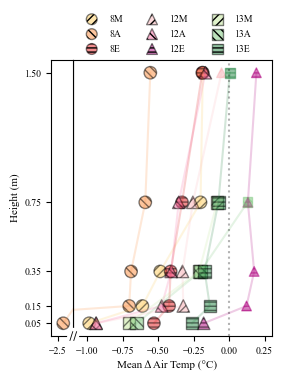

In [31]:
plot_mean_change_temp_profile(mean_df)
plt.show()

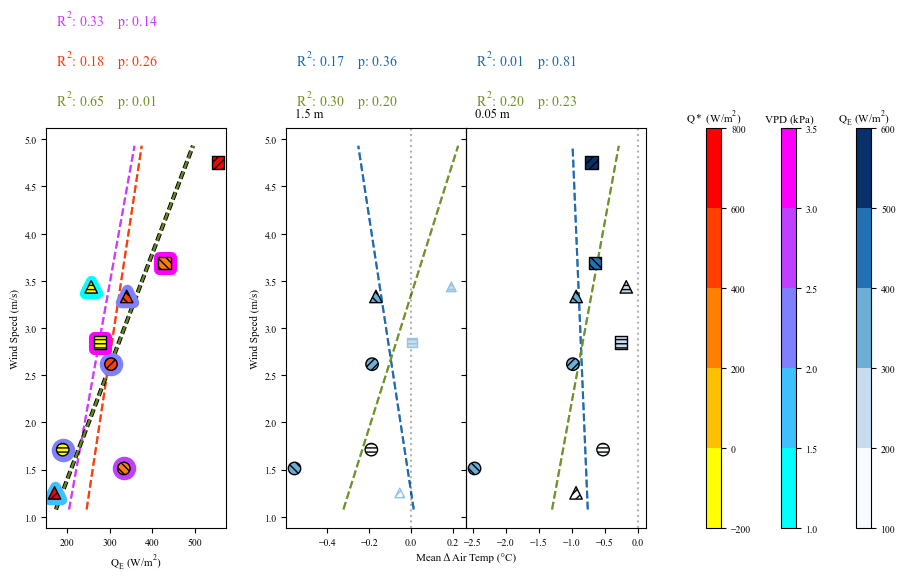

In [32]:
plot_conditions_vs_change(mean_df, show_stats = True)
plt.show()

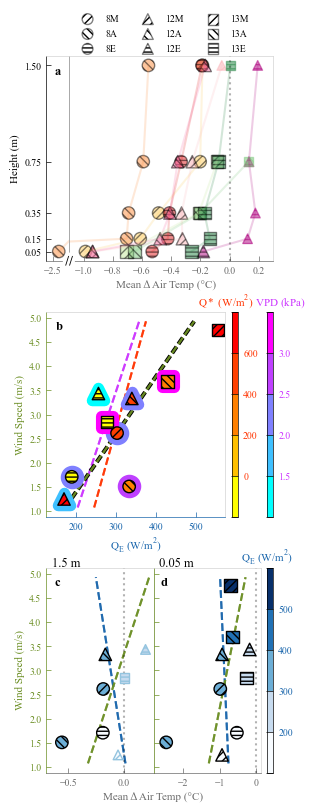

In [33]:
plot_compare_plot_abstract(mean_df, True)